# Theta model 

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
df = sm.datasets.co2.load_pandas().data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


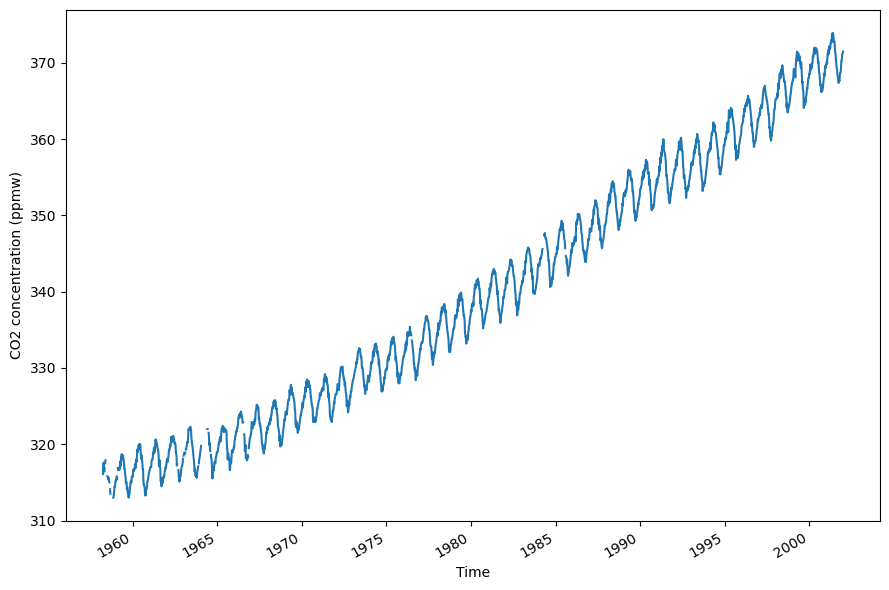

In [4]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
df.isnull().sum()

co2    59
dtype: int64

In [6]:
df = df.interpolate()

df.isnull().sum()

co2    0
dtype: int64

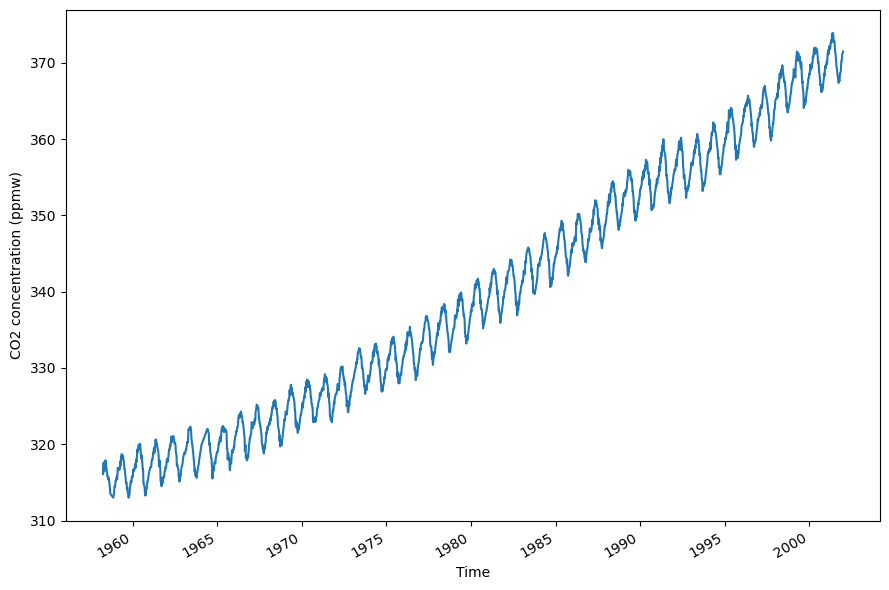

In [7]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

## Modeling 

In [8]:
train = df[:-104]
test = df[-104:]

In [12]:
from statsmodels.tsa.forecasting.theta import ThetaModel

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df[:i].iloc[-window:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'theta':
        pred_theta = []
        
        for i in range(train_len, total_len, window):
            tm = ThetaModel(endog=df[:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)
            
        print(res.summary())

        return pred_theta

In [13]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 52

pred_last_season = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_theta = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'theta')

test = test.copy()

test.loc[:, 'pred_last_season'] = pred_last_season
test.loc[:, 'pred_theta'] = pred_theta

test.head()

                              ThetaModel Results                              
Dep. Variable:                    co2   No. Observations:                 2232
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sat, 29 Oct 2022   Deseas. Method:         Multiplicative
Time:                        15:52:54   Period:                             52
Sample:                    03-29-1958                                         
                         - 12-30-2000                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.025468131021064096
alpha   0.6611560978423418
--------------------------


,co2,pred_last_season,pred_theta
2000-01-08,368.5,367.8,368.688671
2000-01-15,369.0,367.8,368.791990
2000-01-22,369.8,368.3,368.986970
2000-01-29,369.2,369.2,369.111453
2000-02-05,369.1,369.1,369.424445


In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df[:i].iloc[-window:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'theta':
        pred_theta = []
        
        for i in range(train_len, total_len, window):
            tm = ThetaModel(endog=df[:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)
            

        return pred_theta
            
    elif method == 'tes':
        pred_tes = []
        
        for i in range(train_len, total_len, window):
            tes = ExponentialSmoothing(
                df[:i],
                trend='add',
                seasonal='add',
                seasonal_periods=52,
                initialization_method='estimated'
            ).fit()
            
            predictions = tes.forecast(window)
            pred_tes.extend(predictions)

    return pred_tes

In [18]:
pred_tes = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'tes')

test.loc[:, 'pred_tes'] = pred_tes

test.head()

,co2,pred_last_season,pred_theta,pred_tes
2000-01-08,368.5,367.8,368.688671,368.923703
2000-01-15,369.0,367.8,368.791990,368.947827
2000-01-22,369.8,368.3,368.986970,369.229239
2000-01-29,369.2,369.2,369.111453,369.630767
2000-02-05,369.1,369.1,369.424445,369.881112


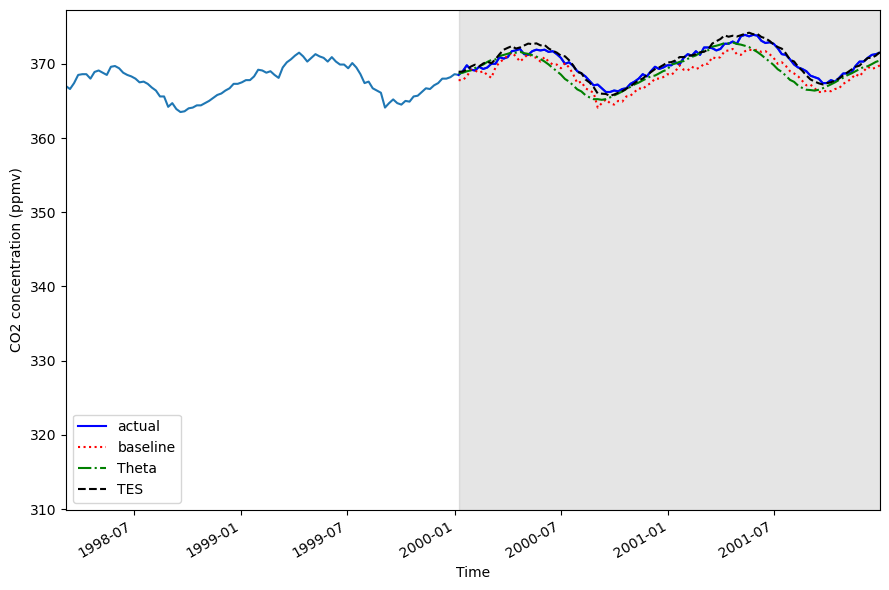

In [23]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.plot(test['co2'], 'b-', label='actual')
ax.plot(test['pred_last_season'], 'r:', label='baseline')
ax.plot(test['pred_theta'], 'g-.', label='Theta')
ax.plot(test['pred_tes'], 'k--', label='TES')

ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmv)')
ax.axvspan('2000-01-08', '2001-12-29', color='#808080', alpha=0.2)

ax.legend(loc='best')

ax.set_xlim('1998-03-07', '2001-12-29')

fig.autofmt_xdate()
plt.tight_layout()

## Evaluation 

In [19]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [20]:
mape_baseline = mape(test['co2'], test['pred_last_season'])
mape_theta = mape(test['co2'], test['pred_theta'])
mape_tes = mape(test['co2'], test['pred_tes'])

print(mape_baseline, mape_theta, mape_tes)

0.36 0.28 0.12


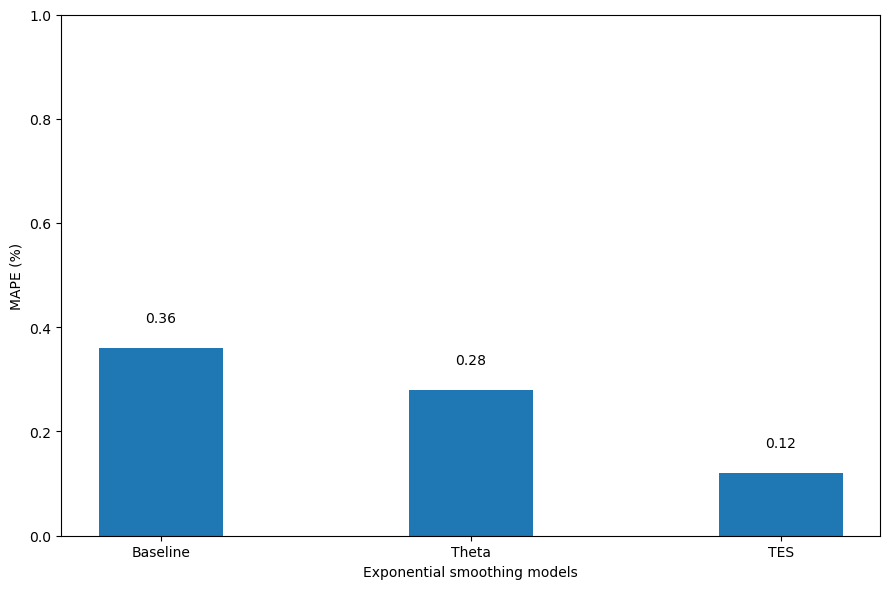

In [24]:
fig, ax = plt.subplots()

x = ['Baseline', 'Theta', 'TES']
y = [mape_baseline, mape_theta, mape_tes]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Exponential smoothing models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()